In [15]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import plotly.express as px

In [16]:
# Define base URL and parameters
base_url = "https://www.footballguys.com/playerhistoricalstats?pos={position}&yr={year}&startwk=1&stopwk=17&profile=p"
positions = ["qb", "rb", "wr", "te"]  # Add other positions as needed
years = range(2000, 2024)  # Loop from 2000 to the current year

# Initialize an empty list to store the data
all_data = []

# Loop through each position and year
for position in positions:
    for year in years:
        url = base_url.format(position=position, year=year)
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Find the table and extract data
        table = soup.find("table", class_="datasmall table")
        if table:  # Ensure the table exists
            # Extract headers
            headers = [header.text.strip() for header in table.find_all("th")]
            headers = ["Year", "Position"] + headers  # Prepend Year and Position
            
            # Extract rows
            rows = table.find_all("tr")
            for row in rows:
                cells = row.find_all("td")
                if cells:  # Ensure there are cells to extract
                    # Create a dictionary for the row
                    row_data = {
                        "Year": year,
                        "Position": position,
                        **{headers[i + 2]: cell.text.strip() for i, cell in enumerate(cells)}
                    }
                    all_data.append(row_data)
        else:
            print(f"No data found for {position} in {year}.")

In [17]:
fantasy_df = pd.DataFrame(all_data, columns=headers)

fantasy_df = fantasy_df.drop(columns=['Rec', 'RecYd', 'Y/Rec', 'RecTD'])

fantasy_df[['Rank', 'FP/G', 'FantPt', 'Age', 'Exp', 'G']] = fantasy_df[['Rank', 'FP/G', 'FantPt', 'Age', 'Exp', 'G']].astype(float)

fantasy_df.columns = ['Year', 'Position', 'Rank', 'Name', 'Age', 'Experience', 'Games_Played', 'Points_Per_Game', 'Total_Points']

fantasy_df['Team'] = fantasy_df['Name'].apply(lambda x: x.split()[-1] if x.split()[-1].isupper() else '')

fantasy_df = fantasy_df[fantasy_df['Rank'] <= 50]

fantasy_df

,Year,Position,Rank,Name,Age,Experience,Games_Played,Points_Per_Game,Total_Points,Team
0,2000,qb,1.0,Daunte Culpepper MIN,23.0,2.0,16.0,21.7,346.5,MIN
1,2000,qb,2.0,Jeff Garcia SF,30.0,2.0,16.0,21.3,340.6,SF
2,2000,qb,3.0,Rich Gannon OAK,35.0,14.0,16.0,19.0,304.1,OAK
3,2000,qb,4.0,Peyton Manning IND,24.0,3.0,16.0,18.5,296.1,IND
4,2000,qb,5.0,Donovan McNabb PHI,24.0,2.0,16.0,18.2,291.5,PHI
...,...,...,...,...,...,...,...,...,...,...
12610,2023,te,46.0,Foster Moreau NO,26.0,5.0,14.0,3.2,45.0,NO
12611,2023,te,47.0,Mo Alie-Cox IND,30.0,7.0,16.0,2.7,43.3,IND
12612,2023,te,48.0,Hayden Hurst CAR,30.0,6.0,9.0,4.7,42.4,CAR
12613,2023,te,49.0,Dawson Knox BUF,27.0,5.0,11.0,3.9,42.4,BUF


In [18]:
# Define the position-specific rank thresholds
position_thresholds = {
    'qb': 15,
    'te': 15,
    'wr': 30,
    'rb': 30
}

# Step 1: Identify the players who have ever been in the top for their position
top_players = fantasy_df[
    fantasy_df.apply(lambda row: row['Rank'] <= position_thresholds[row['Position']], axis=1)
]['Name'].unique()

# Step 2: Filter the DataFrame to keep all rows for these top players
fantasy_df_filtered = fantasy_df[fantasy_df['Name'].isin(top_players)]

# Display the filtered DataFrame
fantasy_df_filtered


,Year,Position,Rank,Name,Age,Experience,Games_Played,Points_Per_Game,Total_Points,Team
0,2000,qb,1.0,Daunte Culpepper MIN,23.0,2.0,16.0,21.7,346.5,MIN
1,2000,qb,2.0,Jeff Garcia SF,30.0,2.0,16.0,21.3,340.6,SF
2,2000,qb,3.0,Rich Gannon OAK,35.0,14.0,16.0,19.0,304.1,OAK
3,2000,qb,4.0,Peyton Manning IND,24.0,3.0,16.0,18.5,296.1,IND
4,2000,qb,5.0,Donovan McNabb PHI,24.0,2.0,16.0,18.2,291.5,PHI
...,...,...,...,...,...,...,...,...,...,...
12585,2023,te,21.0,Gerald Everett LAC,29.0,7.0,14.0,7.8,109.7,LAC
12586,2023,te,22.0,Tyler Higbee LAR,30.0,8.0,15.0,7.2,108.5,LAR
12589,2023,te,25.0,Juwan Johnson NO,27.0,4.0,12.0,7.6,90.8,NO
12595,2023,te,31.0,Pat Freiermuth PIT,25.0,3.0,11.0,6.4,70.7,PIT


In [25]:
# Group by Position and Age, and calculate the mean for Total_Points, Points_Per_Game, and Games_Played
aggregated_df = fantasy_df_filtered.groupby(['Position', 'Age']).agg(
    mean_total_points=('Total_Points', 'mean'),
    mean_points_per_game=('Points_Per_Game', 'mean'),
    total_count=('Name', 'count'),
    mean_games_played=('Games_Played', 'mean')
).reset_index()

# Calculate the total count per position
total_count_per_position = aggregated_df.groupby('Position')['total_count'].transform('sum')

# Calculate the percentage of players in each age group for each position
aggregated_df['percentage_count'] = (aggregated_df['total_count'] / total_count_per_position) * 100

# Display the updated aggregated DataFrame
aggregated_df


,Position,Age,mean_total_points,mean_points_per_game,total_count,mean_games_played,percentage_count
0,qb,21.0,126.600000,10.233333,6,11.500000,0.966184
1,qb,22.0,217.272727,16.868182,22,12.863636,3.542673
2,qb,23.0,224.277500,15.817500,40,13.600000,6.441224
3,qb,24.0,220.203846,15.903846,52,13.576923,8.373591
4,qb,25.0,233.977778,16.266667,54,14.000000,8.695652
...,...,...,...,...,...,...,...
72,wr,35.0,196.408333,14.058333,12,14.666667,1.257862
73,wr,36.0,180.566667,11.588889,9,15.555556,0.943396
74,wr,37.0,202.100000,15.050000,2,13.500000,0.209644
75,wr,40.0,257.100000,16.100000,1,16.000000,0.104822


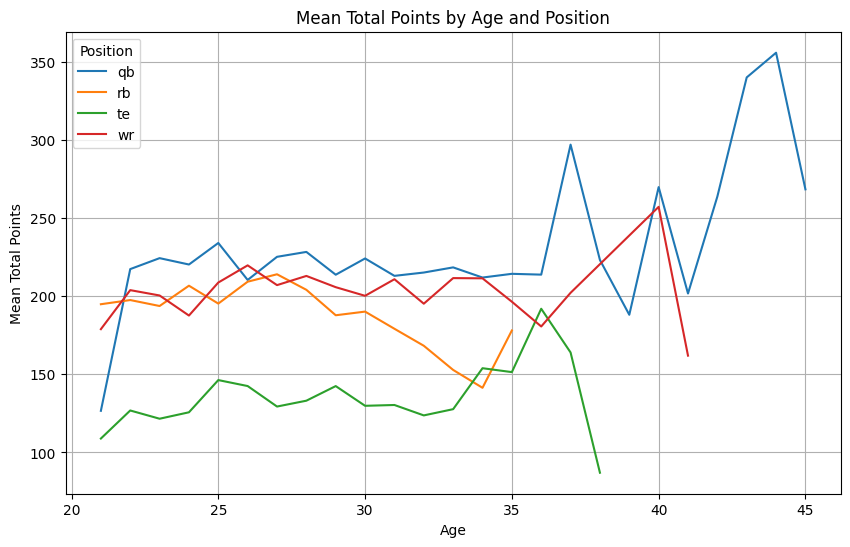

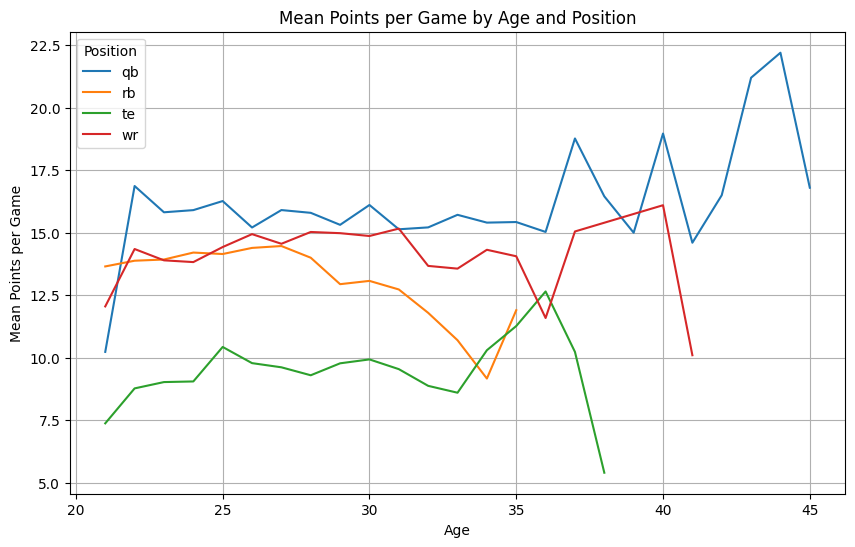

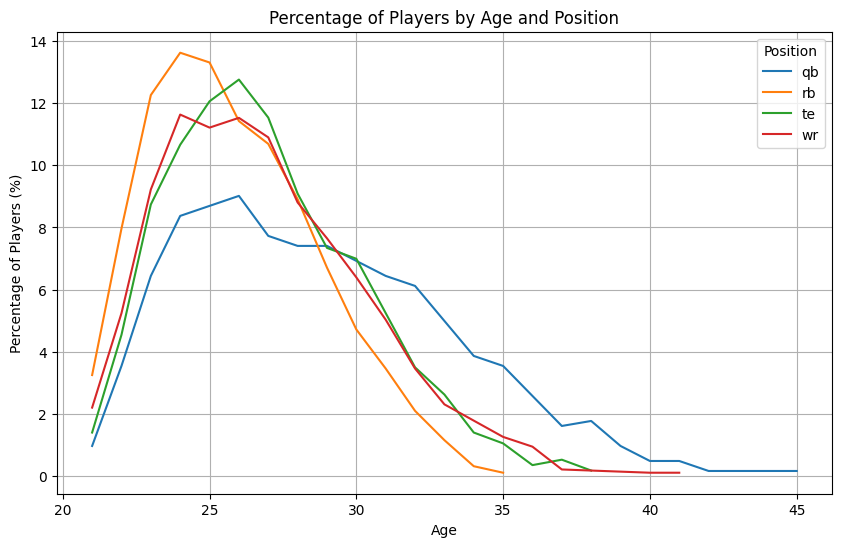

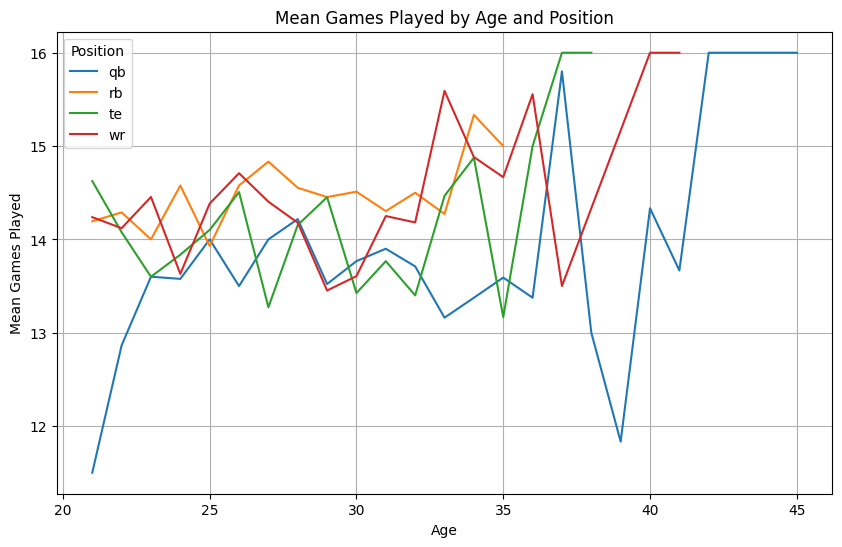

In [26]:
import matplotlib.pyplot as plt

# Plot for Mean Total Points by Age and Position
plt.figure(figsize=(10, 6))
for position in aggregated_df['Position'].unique():
    position_data = aggregated_df[aggregated_df['Position'] == position]
    plt.plot(position_data['Age'], position_data['mean_total_points'], label=position)

plt.title('Mean Total Points by Age and Position')
plt.xlabel('Age')
plt.ylabel('Mean Total Points')
plt.legend(title='Position')
plt.grid(True)
plt.show()

# Plot for Mean Points per Game by Age and Position
plt.figure(figsize=(10, 6))
for position in aggregated_df['Position'].unique():
    position_data = aggregated_df[aggregated_df['Position'] == position]
    plt.plot(position_data['Age'], position_data['mean_points_per_game'], label=position)

plt.title('Mean Points per Game by Age and Position')
plt.xlabel('Age')
plt.ylabel('Mean Points per Game')
plt.legend(title='Position')
plt.grid(True)
plt.show()

# Plot for Percentage Count by Age and Position
plt.figure(figsize=(10, 6))
for position in aggregated_df['Position'].unique():
    position_data = aggregated_df[aggregated_df['Position'] == position]
    plt.plot(position_data['Age'], position_data['percentage_count'], label=position)

plt.title('Percentage of Players by Age and Position')
plt.xlabel('Age')
plt.ylabel('Percentage of Players (%)')
plt.legend(title='Position')
plt.grid(True)
plt.show()

# Plot for Mean Games Played by Age and Position
plt.figure(figsize=(10, 6))
for position in aggregated_df['Position'].unique():
    position_data = aggregated_df[aggregated_df['Position'] == position]
    plt.plot(position_data['Age'], position_data['mean_games_played'], label=position)

plt.title('Mean Games Played by Age and Position')
plt.xlabel('Age')
plt.ylabel('Mean Games Played')
plt.legend(title='Position')
plt.grid(True)
plt.show()
